#ポートフォリオ最適化問題
金融資産運用モデルでもっともシンプルで計算しやすいモデルがポートフォリオ最適化問題です。今後のより複雑なモデルのために一旦ポートフォリオ最適化問題をWildqatで解いてみます。今回は銘柄数を指定して解いてみます。

##ポートフォリオ最適化問題とは？
資産運用の際に資産運用銘柄の選択をしますが、その銘柄の評価を過去のリターンと、銘柄間の相関関係によってリスクを割り出します。その中で銘柄数を指定しながら、過去のリターンと見込んだリスクの中で一番いい選択を計算で行います。

##リターンについて
過去の傾向からリターンの値を出します。
過去のデータが必要ですが、今回は金融データを参考にしたデモデータでやります。

##リスクについて
こちらは銘柄間の分散共分散というものを使いますが、主に相関関係を表す行列式が過去のデータから得られます。

##コスト関数
ポートフォリオ最適化問題を解くためには、QUBOのコスト関数と呼ばれる最小化を行うための数式が必要となります。

今回使用するコスト関数は下記の通りです。

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%20-%5Csum%5Cmu_ix_i%20%2B%20%5Cgamma%5Csum%5Cdelta_%7Bij%7Dx_ix_j%2BB%5Cleft(%5Csum%20x_i-K%5Cright)%5E2">


ただし、xiはi番目の銘柄を選択したかしてないかの{0,1}のバイナリ値。μiはi番目の銘柄の過去のデータからの期待リターン、δijは銘柄iと銘柄jの相関（今回はこれでリスクを見込む）を表す係数。γはどれだけリスクを算定に組み込むかというハイパーパラメータです。

また、最終項に調整パラメータBのついた銘柄数Kを指定するための制約条件が付いています。
制約条件は選択されたxiの個数と指定銘柄数Kが同じになった時にコストが最小の0になるように設計されています。

##例題
早速今回は例題で行って見ます。6つの銘柄から2つの銘柄を選びながら、ダミーのリターンデータとリスクデータを使って最適化を行います。

想定されるリターンは、

<img src="./img/019_0.png">

をダミーデータとして使います。また、想定されるリスクは銘柄間の分散共分散で表現され、

<img src="./img/019_1.png">

とします。早速これをWildqatで準備して見ます。numpyも使いやすいので入れておきます。

In [0]:
import wildqat as wq
import numpy as np
a = wq.opt()

準備ができました。

次にまずリターンの行列を作ります。計算しやすいように対角項にいれた6*6の行列にしておきます。

In [16]:
ret = np.diag([-0.026,-0.031,-0.007,-0.022,-0.010,-0.055])
print(ret)

[[-0.026  0.     0.     0.     0.     0.   ]
 [ 0.    -0.031  0.     0.     0.     0.   ]
 [ 0.     0.    -0.007  0.     0.     0.   ]
 [ 0.     0.     0.    -0.022  0.     0.   ]
 [ 0.     0.     0.     0.    -0.01   0.   ]
 [ 0.     0.     0.     0.     0.    -0.055]]


次にリターンを用意します。これはそのままになります。

In [17]:
ris = [[0,0.0015,0.0012,0.0018,0.0022,0.0012],[0,0,0.0017,0.0022,0.0005,0.0019],[0,0,0,0.0040,0.0032,0.0024],[0,0,0,0,0.0012,0.0076],[0,0,0,0,0,0.0021],[0,0,0,0,0,0]]

print(ris)

[[0, 0.0015, 0.0012, 0.0018, 0.0022, 0.0012], [0, 0, 0.0017, 0.0022, 0.0005, 0.0019], [0, 0, 0, 0.004, 0.0032, 0.0024], [0, 0, 0, 0, 0.0012, 0.0076], [0, 0, 0, 0, 0, 0.0021], [0, 0, 0, 0, 0, 0]]


この２つの行列を足し合わせますが、リスクの導入具合によって値が変わりますので、今回はガンマ=0.5としてみます。

In [20]:
a.qubo = ret + np.asarray(ris)*0.5
print(a.qubo)

[[-0.026    0.00075  0.0006   0.0009   0.0011   0.0006 ]
 [ 0.      -0.031    0.00085  0.0011   0.00025  0.00095]
 [ 0.       0.      -0.007    0.002    0.0016   0.0012 ]
 [ 0.       0.       0.      -0.022    0.0006   0.0038 ]
 [ 0.       0.       0.       0.      -0.01     0.00105]
 [ 0.       0.       0.       0.       0.      -0.055  ]]


無事リターンとリスクを見込んだQUBOmatrixができました。

#銘柄数を指定する
最後に銘柄数を指定する必要があります。銘柄数の指定は上記コスト関数の第三項を使いますが、wildqatではN量子ビットからK量子ビットを選ぶという便利な関数があります。今回はこの制約条件式を導入してくわえてみると、

In [25]:
a.qubo += wq.sel(6,2)
print(a.qubo)

[[-6.026    4.00075  4.0006   4.0009   4.0011   4.0006 ]
 [ 0.      -6.031    4.00085  4.0011   4.00025  4.00095]
 [ 0.       0.      -6.007    4.002    4.0016   4.0012 ]
 [ 0.       0.       0.      -6.022    4.0006   4.0038 ]
 [ 0.       0.       0.       0.      -6.01     4.00105]
 [ 0.       0.       0.       0.       0.      -6.055  ]]


In [30]:
a.sa()

1.5500259399414062


[0, 1, 0, 0, 0, 1]

上記は0から数えて、1番目と5番目が1となりその他は0となっていますので、
1番目と5番目の銘柄が選択されたことになります。

ついでに計算過程のコストの変化を見て見ます。

ここではmatplotlibというツールを使います。

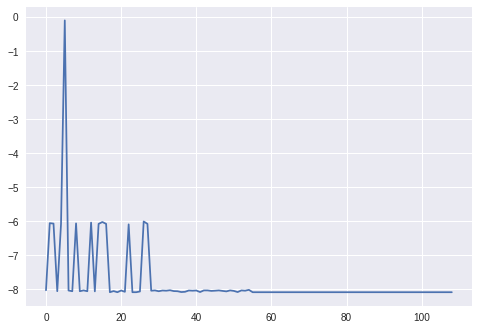

In [31]:
a.plot()

In [32]:
print(a.E[-1])

-8.085050000000003


エネルギーが上下しながら収束していくのが確認できました。以上です。